# HDF5 + mongoDB

This database interface uses `pymongo` as the backend database. The user communicates via the interface `h5rdmtoolbox.database.MongoDB`.

The idea is not to store all data in a mongoDB database. Then we would not have to write an HDF5 file in the first place.<br>
We rather use the database as a **metadata storage**, which is much more efficient to search through. So the steps are:
1. insert (metadata) into the database (the interface takes care how this is done)
2. perform query
3. the interface collects performs query on mongoDB...
4. ...and the interface returns a lazy HDF object to the user

<!-- ![mongoDB_concept](mongoDB_concept.png) -->

<img src="../../_static/mongoDB_concept.png"
     alt="../../_static/mongoDB_concept.png"
     style="margin-right: 10px; height: 200px;" />
     

In [2]:
import pymongo
# from pymongo import MongoClient
from mongomock import MongoClient  # for docs or testing only

from h5rdmtoolbox import tutorial
import h5rdmtoolbox as h5tbx

import numpy as np
from pprint import pprint

h5tbx.use(None)

using("h5py")

## First things first: Connection to the DB:
Connect to the mongod client:

In [3]:
client = MongoClient()
client

mongomock.MongoClient('localhost', 27017)

Create a database and a (test) collection named "digits":

In [4]:
db = client['h5database_notebook_tutorial']
collection = db['digits']

# drop all content in order to start from scratch:
collection.drop()

## Testdata
We will take test data from scikit-learn, namely the hand-written digits ((https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html):

In [5]:
# ! pip install scikit-learn
from sklearn.datasets import load_digits
digits = load_digits()

Fill a HDF5 file with the loaded data. We additionally compute the mean count and two gray occurance properties (dissimilarity and correlation). Those three datasets together with the true digit of the image are linked to the image via HDF dimension scales:

In [6]:
from skimage.feature import graycomatrix, graycoprops

filename = h5tbx.utils.generate_temporary_filename(suffix='.hdf')

with h5tbx.File(filename, 'w') as h5:
    ds_trg = h5.create_dataset('digit',
                               data=digits.target,
                               make_scale=True)
    ds_img = h5.create_dataset('images',
                               shape=(len(digits.images), 8, 8))
    
    ds_mean = h5.create_dataset('mean',
                                shape=(len(digits.images), ),
                                make_scale=True)
    ds_diss = h5.create_dataset('dissimilarity',
                                shape=(len(digits.images), ),
                                make_scale=True)
    ds_corr = h5.create_dataset('correlation',
                                shape=(len(digits.images), ),
                                make_scale=True)
    
    
    for i, img in enumerate(digits.images):
        ds_img[i, :, :] = img
        ds_mean[i] = np.mean(img)
        
        glcm = graycomatrix(img.astype(int), distances=[5], angles=[0], levels=256,
                            symmetric=True, normed=True)
        ds_diss[i] = graycoprops(glcm, 'dissimilarity')[0, 0]
        ds_corr[i] = graycoprops(glcm, 'correlation')[0, 0]
        
    ds_img.dims[0].attach_scale(ds_trg)
    ds_img.dims[0].attach_scale(ds_mean)
    ds_img.dims[0].attach_scale(ds_diss)
    ds_img.dims[0].attach_scale(ds_corr)
    h5.dump()

## Insert (metadata) into the database

To insert data from the HDF5 file into the DB, we need the init the mongoDB interface class.

In [7]:
from h5rdmtoolbox.database import mongo

In [8]:
mdb = mongo.MongoDB(collection=collection)
mdb.collection.drop()  # clean the collection just to be certain that it is really empty

Next, we have two options:
1. Insert a full dataset
2. Insert slices of a dataset according to the dimension scales

We perform both options and understand their meaning in the following:

**First option**

Let's insert the dataset "image" into dat database:

In [9]:
with h5tbx.File(filename) as h5:
    mdb.insert_dataset(h5['images'], axis=None)

This will result in one document:

In [10]:
collection.count_documents({})  # or mdb.collection.count_documents({})

1

Let's find it (quite trivial...):

In [11]:
res = mdb.find_one({})

Let's slice the (lazy) dataset and ask for its shape:

In [12]:
res[()].shape

(1797, 8, 8)

We asked for the shape, to compare it to the second option on how to insert multi-dimensional arrays into the mongoDB:

**Second option**

Now, we will set `axis` to 0. This will "cut" the image dataset into $N=1797$ subarrays and insert them individually. Let's do it and find out what the advantage is afterwards:

In [13]:
mdb.collection.drop()  # clean the collection

In [14]:
with h5tbx.File(filename) as h5:
    mdb.insert_dataset(h5['images'], axis=0, update=False)

Count the number of collections inserted. It is equal to the number of images (1797).

In [15]:
collection.count_documents({})  # or mdb.collection.count_documents({})

1797

The image dataset has dimension scales (you may like to inspect the content of the HDF file again in the `dump()` call at the beginning). By searching e.g. for digit=3, we find the correct slice for an image corresonding to this condition:

In [16]:
one_res = mdb.find_one({'digit': {'$eq': 3}})
one_res[()].shape

(1, 8, 8)

In the version above, we need to work with the xarray object and somehow determine which slice corresponds to digit equal to 3. However, the mongoDB approach does it, too:

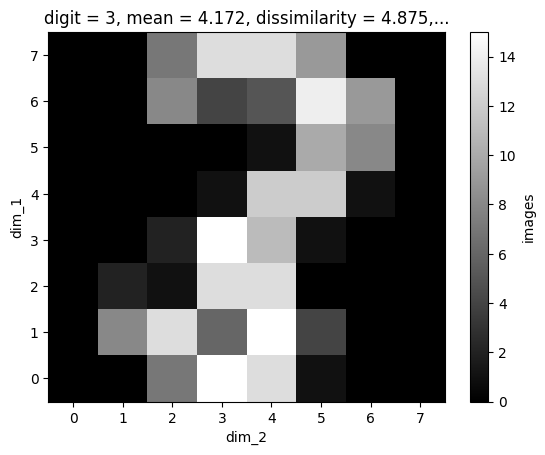

In [17]:
one_res[()].plot(cmap='gray')

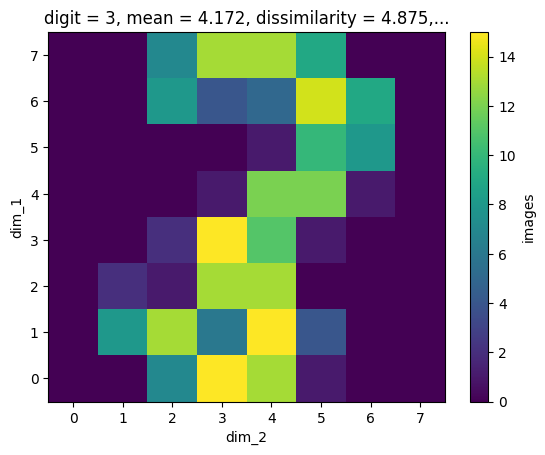

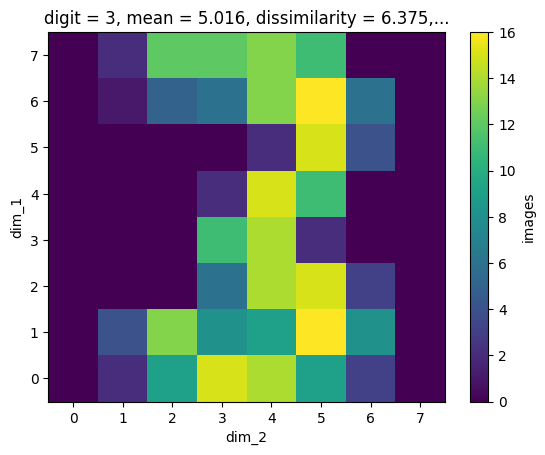

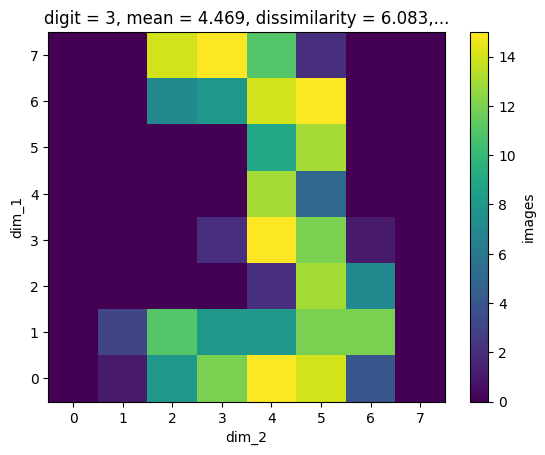

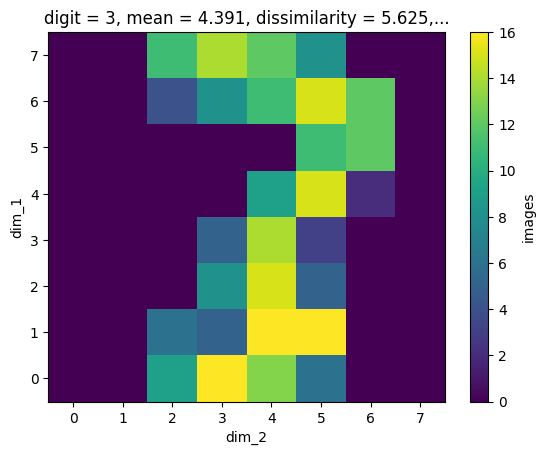

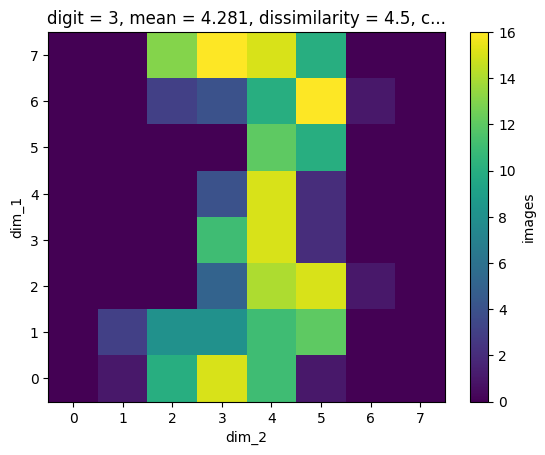

In [18]:
import matplotlib.pyplot as plt

res = mdb.find({'digit': {'$eq': 3}})

# plot the first 5 results:
for i in range(5):
    next(res)[()].plot()
    plt.show()